In [1]:
import cv2
import mediapipe as mp
import time
from scipy import spatial
from IPython.core.display import ProgressBar
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

In [2]:
VIDEO_PATH = '../datasets/rock_dataset_0/clip10/climb.mp4'
HOLDS_PATH = '../datasets/rock_dataset_0/clip10/holds.jpg'

## Extract Video and Pose Information

In [3]:
def get_video_array(vid_path):
    cap = cv2.VideoCapture(vid_path)
    to_read = True
    vid_arr = []
    while to_read:
        to_read, frame = cap.read()
        if to_read:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            vid_arr.append(frame)
    return np.array(vid_arr)

In [4]:
arr = get_video_array(VIDEO_PATH)

arr.shape

(560, 1080, 1920, 3)

In [5]:
NEW_WIDTH = 576
NEW_HEIGHT = 1080

In [6]:
def crop_video(vid_arr, new_width, new_height):
    cropped_video = []
    for i in range(vid_arr.shape[0]):
        frame = vid_arr[i]
        im = Image.fromarray(frame)
        
        width, height = im.size   # Get dimensions

        left = (width - new_width)/2
        top = (height - new_height)/2
        right = (width + new_width)/2
        bottom = (height + new_height)/2

        # Crop the center of the image
        cropped = im.crop((left, top, right, bottom))
        cropped_video.append(np.array(cropped))
    return np.array(cropped_video)

In [7]:
cropped = arr

In [8]:
# cropped = crop_video(arr, NEW_WIDTH, NEW_HEIGHT)

# cropped.shape

In [9]:
# fig, axes = plt.subplots(1, 2)
# axes[0].imshow(arr[0])
# axes[0].set_title('Original')
# axes[1].imshow(cropped[0])
# axes[1].set_title('Cropped')

In [10]:
# gets all coordinate information from video
def get_video_pose(vid_arr):
    pose = mp.solutions.pose.Pose()
    
    dict_coordinates = {'left_hand': [], 'right_hand': [], 'left_hip': [], 'right_hip': [], 'left_leg': [], 'right_leg': []}
    all_landmarks = []
    all_results = []
    frames = []
    for i in range(vid_arr.shape[0]):
        img = vid_arr[i]
        results = pose.process(img)
        
        if results.pose_landmarks is not None:
            frames.append(i)
            lm_list = []
            for id, lm in enumerate(results.pose_landmarks.landmark):  
                h, w, c = img.shape
                cx, cy = int(lm.x*w), int(lm.y*h)
                lm_list.append(cx)
                lm_list.append(cy)
            all_landmarks.append(lm_list)
            all_results.append(results)
            dict_coordinates['left_hand'].append((lm_list[38], lm_list[39])) #left_index - x, y 
            dict_coordinates['right_hand'].append((lm_list[40], lm_list[41])) #right_index - x, y
            dict_coordinates['left_hip'].append((lm_list[46], lm_list[47])) #left_hip - x, y
            dict_coordinates['right_hip'].append((lm_list[48], lm_list[49])) #right_hip - x, y
            dict_coordinates['left_leg'].append((lm_list[62], lm_list[63])) #left_foot - x, y
            dict_coordinates['right_leg'].append((lm_list[64], lm_list[65])) #right_foot - x, y
    
    return frames, all_results, all_landmarks, dict_coordinates

In [11]:
frames, results_arr, landmarks_arr, joint_positions = get_video_pose(cropped)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [12]:
cropped = cropped.take(frames, axis=0)

In [13]:
# compute cosine smilarity between two lm lists 
def check_similarity(list1, list2):
    result = 1 - spatial.distance.cosine(list1, list2)
    return result

In [14]:
# Get significant frames
def get_significant_frames(landmarks):
    significant = []
    for i in range(len(landmarks)):
        if i == 0:
            significant.append(True)
        else:
            if check_similarity(prev, landmarks[i]) < 0.99999:
                significant.append(True)
            else:
                significant.append(False)
        prev = landmarks[i]
    return significant

In [15]:
significances = get_significant_frames(landmarks_arr)

## Extract Hold Information

In [16]:
import sys
sys.path.append('../')

import predict_holds

In [17]:
hold_img = cv2.cvtColor(cv2.imread(HOLDS_PATH), cv2.COLOR_BGR2RGB)
# hold_img = crop_video(np.array([hold_img]), NEW_WIDTH, NEW_HEIGHT)[0]
status, response = predict_holds.predict_holds(hold_img)

In [18]:
def process_hold_response(dic):
    # can union with color frequency analysis in this method
    hold_arr = dic['predictions']
    holds = []
    for elem in hold_arr:
        center_x, center_y = elem['x'], elem['y']
        width, height = elem['width'], elem['height']
        
        x_min = int(center_x - width/2)
        y_min = int(center_y - height/2)
        
        x_max = int(center_x + width/2)
        y_max = int(center_y + height/2)
        
        hold = [(x_min, y_min), (x_max, y_max)]
        holds.append(hold)
    return holds

In [19]:
climb_holds = process_hold_response(response)

## Create New Video with Overlaid Boxes & Poses

In [20]:
# each frame, identify boxes used
# plot boxes used, and pose

In [21]:
def joint_in_hold(joint, hold):
    # joint is (x, y)
    # hold is [(x_min, y_min), (x_max, y_max)]
    jx, jy = joint
    h_xmin, h_ymin = hold[0]
    h_xmax, h_ymax = hold[1]
    
    if jx <= h_xmax and jx >= h_xmin and jy <= h_ymax and jy >= h_ymin:
        return True
    else:
        return False

In [22]:
def get_holds_used(holds, dict_coordinates):
    # should return a list of lists
    # nested list should be an array of True/False
    # each index of the nested list will correspond 
    # to the hold at that index in holds
    
    joint_list = list(zip(dict_coordinates['left_hand'], dict_coordinates['right_hand'], dict_coordinates['left_leg'], dict_coordinates['right_leg']))
    holds_used = []
    for i in range(len(joint_list)): # frames
        used_arr = []
        for h in range(len(holds)):
            hold = holds[h]
            joint_usage = [joint_in_hold(joint, hold) for joint in joint_list[i]]
            if sum(joint_usage) >= 1:
                try: # checking if next frame also uses same hold
                    next_joint_usage = [joint_in_hold(joint, hold) for joint in joint_list[i+1]]
                    if sum(next_joint_usage) >= 1:
                        used_arr.append(True)
                    else:
                        used_arr.append(False)
                except:
                    used_arr.append(True)
            else:
                used_arr.append(False)
        holds_used.append(used_arr)
    return holds_used

In [23]:
climb_holds_used = get_holds_used(climb_holds, joint_positions)

In [24]:
def create_video(vid_arr, holds, holds_used, pose_results, dict_coordinates, frame_significances):
    joint_list = list(zip(dict_coordinates['left_hand'], 
                          dict_coordinates['right_hand'], 
                          dict_coordinates['left_hip'], 
                          dict_coordinates['right_hip'], 
                          dict_coordinates['left_leg'], 
                          dict_coordinates['right_leg']))
    mp.solutions.drawing_utils.draw_landmarks
    plotted_frames = []
    for t in range(vid_arr.shape[0]):
        if frame_significances[t] == False:
            continue
        else:
            print(t)
            used = holds_used[t]
            results = pose_results[t]

            frame = vid_arr[t]
            print("Drawing Holds")
            for h in range(len(used)):
                # drawing holds used
                if used[h]:
                    frame = cv2.rectangle(frame, holds[h][0], holds[h][1], (0, 255, 120), 5)
            # draw pose
            print("Drawing Pose")
            mp.solutions.drawing_utils.draw_landmarks(frame, results.pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS)

            # draw keypoints
            print("Drawing Keypoints")
            for j in range(len(joint_list[t])):
                cx, cy = joint_list[t][j]
                frame = cv2.circle(frame, (cx, cy), 5, (255,0, 150), cv2.FILLED)
            plotted_frames.append(frame)
    return np.array(plotted_frames)

In [25]:
plotted_vid = create_video(cropped, climb_holds, climb_holds_used, results_arr, joint_positions, significances)

0
Drawing Holds
Drawing Pose
Drawing Keypoints
70
Drawing Holds
Drawing Pose
Drawing Keypoints
71
Drawing Holds
Drawing Pose
Drawing Keypoints
72
Drawing Holds
Drawing Pose
Drawing Keypoints
73
Drawing Holds
Drawing Pose
Drawing Keypoints
74
Drawing Holds
Drawing Pose
Drawing Keypoints
75
Drawing Holds
Drawing Pose
Drawing Keypoints
76
Drawing Holds
Drawing Pose
Drawing Keypoints
77
Drawing Holds
Drawing Pose
Drawing Keypoints
78
Drawing Holds
Drawing Pose
Drawing Keypoints
79
Drawing Holds
Drawing Pose
Drawing Keypoints
121
Drawing Holds
Drawing Pose
Drawing Keypoints
122
Drawing Holds
Drawing Pose
Drawing Keypoints
123
Drawing Holds
Drawing Pose
Drawing Keypoints
124
Drawing Holds
Drawing Pose
Drawing Keypoints
125
Drawing Holds
Drawing Pose
Drawing Keypoints
126
Drawing Holds
Drawing Pose
Drawing Keypoints
127
Drawing Holds
Drawing Pose
Drawing Keypoints
131
Drawing Holds
Drawing Pose
Drawing Keypoints
133
Drawing Holds
Drawing Pose
Drawing Keypoints
134
Drawing Holds
Drawing Pose
D

In [26]:
plotted_vid.shape

(77, 1080, 1920, 3)

In [27]:
cropped_plotted_vid = crop_video(plotted_vid, NEW_WIDTH, NEW_HEIGHT)

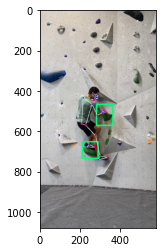

In [28]:
plt.imshow(cropped_plotted_vid[15])

In [29]:
frameSize = (NEW_WIDTH, NEW_HEIGHT)
fourcc= cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter('test.avi', fourcc, 5, (NEW_WIDTH, NEW_HEIGHT), isColor=True)

for i in range(cropped_plotted_vid.shape[0]):
    img = cropped_plotted_vid[i]
    out.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

out.release()